In [28]:
import numpy as np
from itertools import product

class AMModel(object):
    '''
       AM model based on Experiment 2 KTH, SR, AM SPI Mechanism
    
    '''
    def __init__(self, **kwargs):
        
        self.numPlayers = 2
        self.value = np.array([200, 250, 320])
        self.cost = np.array([130, 80, 10])
        
        self.eps = kwargs.get('eps', 0.01)        
        
        # number of individual actions
        self.numiActions = 9
        self.buyerActions = np.array(list(product([0, 1, 2], repeat=2)))
        self.sellerActions = np.array(list(product([0, 1, 2], repeat=2)))
        
        self.memory = kwargs.get('memory', 0)
        self.true_value_index = kwargs.get('true_value',2)
        self.true_cost_index = kwargs.get('true_cost',2)
        self.trueValue = self.value[self.true_value_index]
        self.trueCost = self.cost[self.true_cost_index]
        
        self.buyerInvestment = 0
        self.sellerInvestment = 0       
#         self.trueValue = self.init_TrueValue(self.sellerInvestment)
#         self.trueCost = self.init_TrueCost(self.buyerInvestment)
        
        
        self.numActions = self.numiActions ** self.numPlayers
        self.numStates = self.numiActions ** (self.numPlayers * self.memory)
        
        self.indexActions = self.init_indexActions()
        self.Prices = self.init_Prices()
        self.Profits,self.Penalty = self.init_Profits()

        # QL
        self.delta = kwargs.get('delta', 0.95)
        self.alpha = kwargs.get('alpha', 0.15) * np.ones(self.numPlayers)
        self.beta = kwargs.get('beta', 0.0005) * np.ones(self.numPlayers)
        
        self.lengthStates = self.numPlayers * self.memory
        self.lengthStrategies = self.numPlayers * self.numStates
        
        self.Q = self.init_Q()

        self.cActions = self.init_cActions()
        
        
    def init_indexActions(self):
        
        indexActions = []
        for i in range(self.numActions):
            
            indexActions.append(self.convertNumberBase(i, self.numiActions, self.numPlayers))
            
        indexActions = np.array(indexActions)
        
        return indexActions

    def init_TrueValue(self, i):
        if i == 0:
            return 200
        elif i == 25:
            return 250
        else:
            return 320

    def init_TrueCost(self, i):
        if i == 0:
            return 130
        elif i == 25:
            return 80
        else:
            return 10
    
    def init_Prices(self):
        
        pricesArray = np.zeros((3, 3))
        for cb in range(0, 3):
            for vs in range(0, 3):
                
                # (vs-200) - (130-cb) + 165
                
                pricesArray[cb][vs] = (self.value[vs] - 200) - (130 - self.cost[cb]) + 165
                
        return pricesArray

    
    def init_Profits(self):
        Profits = np.zeros((2, self.numActions, self.numPlayers))
        Actions = np.zeros((self.numActions, 4))
        
        Penalty = np.zeros((2, self.numActions, self.numPlayers))
        
        for i in range(self.numActions):
            
            b = int(self.indexActions[i][0])
            s = int(self.indexActions[i][1])
            
            vb, cb = self.buyerActions[b]
            vs, cs = self.sellerActions[s]
            penalb = 0
            penals = 0
            
            Actions[i] = vb, cb, vs, cs

            
            pb_na = self.trueValue - self.Prices[cb][vs] - self.buyerInvestment

            # profit for seller: price - true cost - investment_seller
            ps_na = self.Prices[cb][vs] - self.trueCost - self.sellerInvestment
            
            Profits[0][i] = [pb_na, ps_na]
            Penalty[0][i] = [penalb,penals]

            
            if vb == 0:
                # no_trade
                pb1 = 0 - self.buyerInvestment
                ps1 = 0 - self.sellerInvestment

                
            elif vb == 1:
                pb1 = 0.5 * 0 + 0.5 * (self.trueValue - 205) - self.buyerInvestment
                ps1 = 0.5 * 0 + 0.5 * (205 - self.trueCost) - self.sellerInvestment

                
            else:
                pb1 = 0.5 * (self.trueValue - 205) + 0.5 * (self.trueValue - 255) - self.buyerInvestment
                ps1 = 0.5 * (255 - self.trueCost) + 0.5 * (205 - self.trueCost) - self.sellerInvestment

                
            if vb == vs:
                ps1 = ps1 
                
            else:
                ps1 = ps1 - 300
                penals = -300

                
            if cs == 0:
                # no_trade
                pb2 = 0 - self.buyerInvestment
                ps2 = 0 - self.sellerInvestment

                
            elif cs == 1:
                pb2 = 0.5 * 0 + 0.5 * (self.trueValue - 125) - self.buyerInvestment
                ps2 = 0.5 * 0 + 0.5 * (125 - self.trueCost) - self.sellerInvestment

                
            else:
                pb2 = 0.5 * (self.trueValue - 125) + 0.5 * (self.trueValue - 75) - self.buyerInvestment
                ps2 = 0.5 * (125 - self.trueCost) + 0.5 * (75 - self.trueCost) - self.sellerInvestment

                
            if cs == cb:
                pb2 = pb2 

                
            else:
                pb2 = pb2 - 300
                penalb = -300

                
            pb_a = 0.5 * (pb1 + pb2) 
            ps_a = 0.5 * (ps1 + ps2)  

           

            Profits[1][i] = [pb_a, ps_a]
            Penalty[1][i] = [penalb,penals]
            

        return Profits,Penalty

    
    def init_Q(self):
        Q = np.zeros((self.numActions, self.numiActions, self.numPlayers))
        for iReport in range(self.numiActions):
            
            den = np.count_nonzero(self.indexActions == iReport,axis = 0,keepdims = True) * (1 - self.delta)
            Q[:, iReport,:] = np.ma.array((1 - self.eps)*self.Profits[0]+self.eps * self.Profits[1],
                                mask=(self.indexActions != iReport)).sum(axis = 0) / den
        return Q


    def init_cActions(self):
        """Initialize cActions (used for q-learning)"""
        
        x = np.arange(self.numPlayers - 1, -1, -1)
        cActions = self.numiActions ** x
        
        return cActions
    
    @staticmethod
    def convertNumberBase(n, b, l):
        '''
        Converts an integer n from base 10 to base b,
        generating a vector of integers of length l
        '''
        tmp = n
        ans = np.zeros(l)
        for i in range(1, l+1):
            ans[l-i] = int(tmp % b)
            tmp = np.floor(tmp/b)
        return ans



    

In [35]:
np.exp(-100000/5000)

2.061153622438558e-09

In [29]:
import numpy as np

# from AMModel import AMModel

    
class AM_Qlearning(object):
    '''
        Qlearning based on AM model
    '''
    def __init__(self, **kwargs):
        
        self.alpha = kwargs.get('alpha',0.55)
        self.beta = kwargs.get('beta',0.0005)
        self.eps = kwargs.get('eps',0.95)
        self.convergedtime = kwargs.get('convergedtime',500)
        self.numSessions = kwargs.get('numSessions',10)
        self.maxIters = kwargs.get('maxIters',100000)
        self.game = AMModel(alpha = self.alpha, beta = self.beta,eps = self.eps)
        self.initial_state = kwargs.get('initial_state',1)
        
               
    def computePPrime(self, strategyPrime, iters):
        
        pPrime = np.zeros(self.game.numPlayers)
        #  Greedy with probability 1-epsilon, with exponentially decreasing epsilon
        
        for iPlayer in range(self.game.numPlayers):
            
            if np.random.uniform(0,1) < np.exp(-self.game.beta[iPlayer]*iters):

                pPrime[iPlayer] = np.floor(self.game.numiActions*np.random.uniform(0,1))
            else:
                pPrime[iPlayer] = strategyPrime[iPlayer]
                
        return pPrime


    def q_learning(self):
        # Initializing various quantities

        indexStrategies = np.zeros((self.game.numPlayers,self.numSessions))

        indexConverge = np.zeros((self.game.numPlayers,self.numSessions))
        
        self.profit_list = np.full((self.numSessions,self.maxIters,self.game.numPlayers),np.nan)
        self.penalty_list = np.full((self.numSessions,self.maxIters,self.game.numPlayers),np.nan)

        # Loop over numSessions
        for iSession in range(self.numSessions):
            
            
            # Learning Phase
            
            # Initialization
            self.Q = self.game.Q.copy()
            self.strategyPrime = np.zeros(self.game.numPlayers)
            maxVal = np.zeros(self.game.numPlayers)
            initialAction = np.floor(np.random.uniform(0,1,(2))*self.game.numiActions)   
            strategyPrime = initialAction
            
            # Loop
            itersInStrategy = 0
            convergedSession = -1
            
            strategyFix = np.zeros(self.game.numPlayers)
            
            for iters in range(self.maxIters):
                
                # Iterations counter

                # Compute pPrime by balancing exploration vs. exploitation

                pPrime = self.computePPrime(strategyPrime, iters)
                #pPrime = strategyPrime
                actionPrime = int(np.sum(self.game.cActions*pPrime)) 

                state = actionPrime
                state1 = int(np.sum(self.game.cActions*strategyPrime)) 
                
                for iPlayer in range(self.game.numPlayers):
                    
                    temp_q = self.Q[state,:,iPlayer]
                    maxVal[iPlayer] = np.max(temp_q)

                    strategyPrimeList = np.where(temp_q == maxVal[iPlayer])[0]
                    
                    u = np.random.uniform(0, 1)
                    strategyPrime[iPlayer] = strategyPrimeList[int(len(strategyPrimeList)*u)]
                    
                    # Q matrices and strategies update
                    oldq = self.Q[state, int(pPrime[iPlayer]), iPlayer]
                    
                    
                    if np.random.uniform(0, 1) < 1 - np.exp(-iters/5000):
                        profits = self.game.Profits[0][state, iPlayer]
                        self.profit_list[iSession,iters,iPlayer] = self.game.Profits[0][state,iPlayer]
                        self.penalty_list[iSession,iters,iPlayer] = self.game.Penalty[0][state,iPlayer]
                        
                    else:
                        profits = self.game.Profits[1][state, iPlayer]
                        self.profit_list[iSession,iters,iPlayer] = self.game.Profits[1][state,iPlayer]
                        self.penalty_list[iSession,iters,iPlayer] = self.game.Penalty[1][state,iPlayer]
                        
                        
                    newq = oldq + self.game.alpha[iPlayer] * (profits + \
                                                self.game.delta * maxVal[iPlayer] - oldq)
                    self.Q[state1, int(pPrime[iPlayer]), iPlayer] = newq

                # Assessing convergence
                if np.array_equiv(strategyPrime, pPrime):
                    itersInStrategy = itersInStrategy + 1
                
                else:
                    itersInStrategy = 1

                # Check for convergence in strategy
                if convergedSession == -1:
                    # Maximum number of iterations exceeded
                    if iters >= self.maxIters - 1:
                        convergedSession = 0


                    if itersInStrategy == self.convergedtime:
                        convergedSession = 1

                    strategyFix = strategyPrime.copy()               #testing

                # Check for loop exit criteria
                if convergedSession != -1:
                    break
                # if no converge yet, update and iterate
    
            indexConverge[:,iSession] = (convergedSession, iters)
            indexStrategies[:,iSession] = strategyFix
            self.indexConverge = indexConverge
            self.indexStrategies = indexStrategies
            print(iSession,convergedSession)

        return indexConverge, indexStrategies



    

In [30]:
K = AM_Qlearning(eps = 0.9)
K.q_learning()

0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1


(array([[1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00],
        [1.5464e+04, 1.2403e+04, 1.3307e+04, 1.4103e+04, 1.2982e+04,
         1.3303e+04, 1.2693e+04, 1.2140e+04, 1.3653e+04, 1.3232e+04]]),
 array([[5., 7., 5., 5., 8., 8., 8., 8., 8., 8.],
        [7., 8., 5., 8., 8., 7., 8., 8., 7., 7.]]))

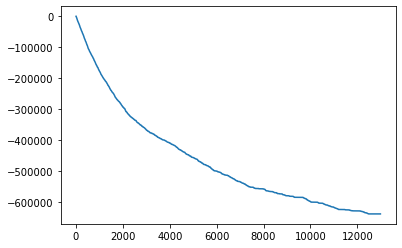

In [32]:
import matplotlib.pyplot as plt
plt.plot(K.penalty_list[4,:,1].cumsum())

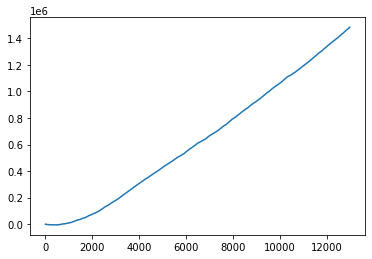

In [33]:
import matplotlib.pyplot as plt
plt.plot(K.profit_list[4,:,1].cumsum())

In [14]:
np.sum(K.penalty_list[0,:int(K.indexConverge[1,0]),0]!=0)/ \
    (np.sum(~np.isnan(K.penalty_list[0,:int(K.indexConverge[1,0]),0]))-500)

0.09836065573770492

In [28]:
K.profit_list[:,0]

array([[   0.  ,  -11.25],
       [  35.  ,  275.  ],
       [   0.  ,    0.  ],
       [   0.  ,    0.  ],
       [   0.  ,    0.  ],
       [   0.  ,    0.  ],
       [   0.  ,    0.  ],
       [  35.  ,  110.  ],
       [   0.  , -105.  ],
       [ -40.  ,    0.  ]])

In [23]:
from multiprocessing import Pool

def single_process(alpha):

    converge_list = [10000]
    beta_list = [0.0005]
    for cl in converge_list:
        df = pd.DataFrame(columns=['alpha','beta','total_sessions',
                                   'converged_times','i ndexStrategie','indexConverge'])
        path = 'SR_parallel_result'
        if not os.path.exists(path):
            os.mkdir(path)

        for beta in beta_list:
            temp_model = AM_Qlearning(alpha = alpha,beta = beta, convergedtime = cl)
            temo_model.q_learning()
            indexConverge,indexStrategies = q_learning()
            df = df.append({'alpha':alpha,'beta':beta,'total_sessions':kth.numSessions,
                            'converged_times':cl,'indexStrategie':indexStrategies,
                            'indexConverge':indexConverge },ignore_index=True)
            print('alpha:',alpha,' beta:',beta,' converged_times:',cl,' finish!')

        with open(path + '/' + 'a_'+ str(alpha) + 'b_'+ str(beta) + '_cl_' + str(cl) + '.pkl', 'wb') as f:
            pickle.dump(df, f)

def run_complex_operations(operation, input, pool):
    pool.map(operation, input)



In [24]:
processes_count = 10
     

alpha_list = np.linspace(0.025,0.25,2)
processes_pool = Pool(processes_count)
run_complex_operations(single_process,alpha_list , processes_pool)

Process SpawnPoolWorker-24:
Process SpawnPoolWorker-23:
Traceback (most recent call last):
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
Traceback (most recent call last):
AttributeError: Can't get attribute 'single_process' on <module '__main__' (built-in)>
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  F

KeyboardInterrupt: 

python3.9/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Process SpawnPoolWorker-29:
Traceback (most recent call last):
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Traceback (most recent call last